In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [45]:
df = pd.read_csv('bpic15.preprocessed.labeled.mapped.csv')

In [46]:
df_res_events = df.groupby('org:resource').size().sort_values(ascending=False).iloc[:]
print(df_res_events)
active_res = list(df_res_events.index)
print(active_res)

df = df[df['org:resource'].isin(active_res)]

org:resource
560781      12644
560454      10170
560872       9503
560530       9295
560673       9243
            ...  
1898401         9
3148844         9
3175153         7
10716070        5
560427          2
Length: 71, dtype: int64
[560781, 560454, 560872, 560530, 560673, 560604, 560752, 560602, 560532, 560749, 2670601, 560890, 560741, 3273854, 560458, 560600, 560852, 2013365, 560519, 560429, 1254625, 1550894, 560912, 560696, 560821, 560521, 560608, 560925, 8492512, 560598, 11744364, 5025869, 3442724, 560596, 560462, 560881, 560613, 9264148, 22445896, 4634935, 560849, 560812, 560950, 3122446, 560894, 560594, 6993893, 560589, 20987361, 9106499, 5726485, 560922, 12941730, 560999, 560431, 6925826, 6, 560464, 560528, 13412649, 3069866, 11345232, 560796, 4936828, 13412010, 560713, 1898401, 3148844, 3175153, 10716070, 560427]


0     [560852, 1254625, 3148844, 560532, 560749, 560...
1     [560849, 560532, 560604, 560872, 560600, 56053...
2     [560849, 560429, 560604, 560532, 560922, 56087...
3     [560600, 3442724, 560613, 560821, 560530, 5607...
4     [560532, 560673, 560454, 2013365, 560922, 5609...
5     [560429, 560925, 560528, 560872, 560741, 56053...
6     [560602, 1254625, 560749, 560752, 560821, 5607...
7     [1550894, 560604, 3273854, 560600, 560462, 560...
8     [1550894, 560604, 3273854, 560600, 560462, 560...
9             [2013365, 560458, 560696, 560741, 560589]
10                                             [560519]
11                                     [560600, 560429]
Name: org:resource, dtype: object
[np.int64(560429), np.int64(560454), np.int64(560458), np.int64(560462), np.int64(560519), np.int64(560530), np.int64(560532), np.int64(560589), np.int64(560600), np.int64(560602), np.int64(560604), np.int64(560613), np.int64(560673), np.int64(560696), np.int64(560741), np.int64(560749), np.in

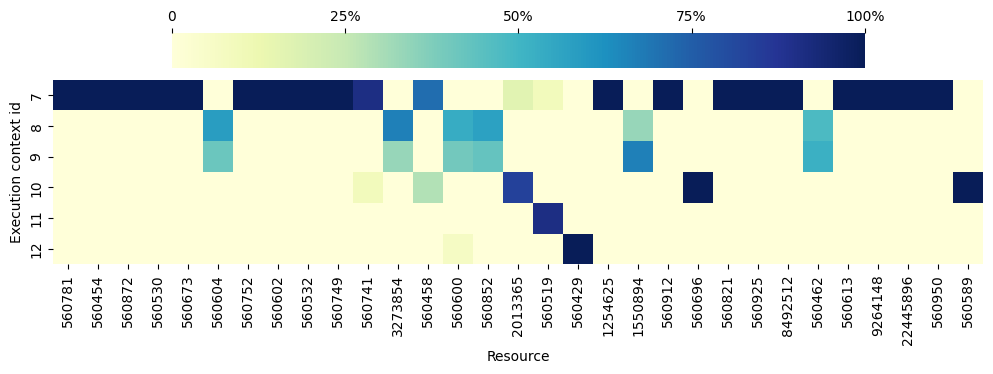

In [47]:
df_co_events = df.groupby(['activity_type', 'time_type']).size().reset_index().sort_values(0, ascending=False)
df_co_events = df_co_events.rename(columns={0: 'n_events'}).reset_index()[['activity_type', 'time_type', 'n_events']]
#print(df_co_events)

df_co_res = df.groupby(['activity_type', 'time_type'])['org:resource'].unique()

df_x = df_co_events.join(df_co_res, on=['activity_type', 'time_type'])
print(df_x['org:resource'])

all_resources = sorted(df['org:resource'].unique())

from collections import defaultdict

selected_resources = set()

# Jaccard distance
co_resources = []

for i, res in enumerate(df_x['org:resource']):
    #print(set(sorted(res)))
    if i >= 6:
        for r in res:
            selected_resources.add(r)
    co_resources.append(set(res))

print(sorted(selected_resources))
print(len(selected_resources))

selected_resources = sorted(selected_resources, key=lambda x: active_res.index(x))
print(df_res_events.loc[selected_resources])
    
df_res_co_events = defaultdict(lambda: defaultdict(lambda: 0))
for key, events in df.groupby(['org:resource', 'activity_type', 'time_type']):
    r = key[0]
    at = key[1]
    tt = key[2]
    if at == '0-1-4-5' and tt == 'Sun':
        co = '7'
    elif at == '3' and tt == 'Sat':
        co = '8'
    elif at == '2' and tt == 'Sat':
        co = '9'
    elif at == '6' and tt == 'M-T-W-T-F':
        co = '10'
    elif at == '8' and tt == 'Sat':
        co = '11'
    elif at == '7' and tt == 'Sat':
        co = '12'
    else:
        co = 'others'
    df_res_co_events[r][co] = len(events)
        
df_res_co_events = pd.DataFrame(df_res_co_events).fillna(0).T
df_res_co_events = df_res_co_events[['7', '8', '9', '10', '11', '12']]
df_res_co_events = df_res_co_events.loc[selected_resources]
df_res_co_events = df_res_co_events.div(df_res_co_events.sum(axis=1), axis=0)

mat_jac_dist = defaultdict(lambda: defaultdict(lambda: 0))

for i in range(len(co_resources)):
    for j in range(len(co_resources)):
        u = co_resources[i]
        v = co_resources[j]
        mat_jac_dist[i+1][j+1] = 1 - len(u.intersection(v)) / len(u.union(v))

print(mat_jac_dist)

df_jac_dist = pd.DataFrame(mat_jac_dist).loc[1:7][list(range(1, 7+1))]
#df_jac_dist

f, ax = plt.subplots(figsize=(12, 3))
sns.heatmap(df_res_co_events.T, ax=ax, cmap='YlGnBu', annot=False, cbar_kws = dict(use_gridspec=False,location="top"))
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .5, .75, 1])
cbar.set_ticklabels(['0', '25%', '50%', '75%', '100%'])
plt.xlabel("Resource")
plt.ylabel("Execution context id")
plt.show()